In [1]:
!pip install shap
!pip install lime
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a8720976a5414ea708996bc7b4ec9c1dcc5574c6eee6b87dc3eb51376b33b0d4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00


In [2]:
import shap
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# LIME packages
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from sklearn.linear_model import Ridge, lars_path
from lime.lime_text import explanation
from functools import partial
import scipy as sp
from sklearn.utils import check_random_state
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tqdm import tqdm

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
!pip install gdown

In [4]:
'''
https://drive.google.com/file/d/1x_D1Feh88EFHQ63SEe55sAymUnztqzeK/view?usp=drivesdk
https://drive.google.com/file/d/1Kqf7-0Jkp1doGJWyhgxW1ku738IO4xji/view?usp=drivesdk
'''

'\nhttps://drive.google.com/file/d/1x_D1Feh88EFHQ63SEe55sAymUnztqzeK/view?usp=drivesdk\nhttps://drive.google.com/file/d/1Kqf7-0Jkp1doGJWyhgxW1ku738IO4xji/view?usp=drivesdk\n'

In [5]:
!gdown 1x_D1Feh88EFHQ63SEe55sAymUnztqzeK
!gdown 1Kqf7-0Jkp1doGJWyhgxW1ku738IO4xji

Downloading...
From: https://drive.google.com/uc?id=1x_D1Feh88EFHQ63SEe55sAymUnztqzeK
To: /content/train.pkl
100% 3.59M/3.59M [00:00<00:00, 152MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Kqf7-0Jkp1doGJWyhgxW1ku738IO4xji
To: /content/test.pkl
100% 762k/762k [00:00<00:00, 72.8MB/s]


In [6]:
FILE_PATH = "train.pkl"

with open(FILE_PATH, 'rb') as f:
    df_train = pickle.load(f)

In [7]:
FILE_PATH = "test.pkl"

with open(FILE_PATH, 'rb') as f:
    df_test = pickle.load(f)

In [8]:
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

In [9]:
df_train.head()

,tweet,label,tweet_with_out_emojis,cleaned_data,Root Stemming,Light Stemming
0,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,1,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,مهند ياحبيبي تدور لبش اي احد متاكد ابو ...,هند حبب تدر لبش اي احد تكد ابو جسم ايدر,مهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ما...
1,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,3,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفرين اعتقال عشرات الشباب قريه باسوطه ريف ...,حلب عفر عقل عشر شبب قره بسط ريف عفر قوت هرب عش...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...
2,انا نفسي مره اجرب اكون ليك حد اقرب : ),3,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,مره جرب اكن ليك قرب,مره اجرب اكون ليك اقرب
3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,صرح حسس خزي كتف مثل شرف اوليمبياد عوز صحه ريض,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...
4,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,0,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,عجل يطل ابو بسل يفز دهب اوليمبياد جودو بطل علم...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...


In [10]:
label_to_class = [
    'none',
    'anger',
    'joy',
    'sadness',
    'love',
    'sympathy',
    'surprise',
    'fear'
]
label_to_class_dic = {
    0:'none',
    1:'anger',
    2:'joy',
    3:'sadness',
    4:'love',
    5:'sympathy',
    6:'surprise',
    7:'fear'
}

In [11]:
def map_label_to_class(indices, classes):
  return [classes[idx] for idx in indices]

In [12]:
def create_confusion_matrix(y_pred):
  # creatin a confusion matrix
  y_true = map_label_to_class(df_test['label'], label_to_class)
  y_pred = map_label_to_class(y_pred, label_to_class)
  cm = confusion_matrix(y_true, y_pred, labels=label_to_class)
  # create a DataFrame for the confusion matrix with class names as index and columns
  cm_df = pd.DataFrame(cm, index=label_to_class, columns=label_to_class)

  # create a heatmap for visualization
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

## Naive Bayes Model

In [13]:
# use Tfidf Vectorizer root stemming
tfidf_vectorizer_rs = TfidfVectorizer()
# fit and transform the training data
X_train_tfidf_rs = tfidf_vectorizer_rs.fit_transform(df_train['Root Stemming'])
# transform the test data using the same vectorizer
X_test_tfidf_rs = tfidf_vectorizer_rs.transform(df_test['Root Stemming'])

# use Tfidf Vectorizer light stemming
tfidf_vectorizer_ls = TfidfVectorizer()
# fit and transform the training data
X_train_tfidf_ls = tfidf_vectorizer_ls.fit_transform(df_train['Light Stemming'])
# transform the test data using the same vectorizer
X_test_tfidf_ls = tfidf_vectorizer_ls.transform(df_test['Light Stemming'])

## Using MultinomialNB

In [14]:
nb_vec = MultinomialNB(force_alpha=True, alpha=0.1, fit_prior=True)
nb_vec.fit(X_train_tfidf_rs, df_train['label'])

# test accuracy of tf-idf vectorizer
y_pred = nb_vec.predict(X_test_tfidf_rs.toarray())
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.604635761589404


In [15]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

              precision    recall  f1-score   support

        none       0.54      0.78      0.64       229
       anger       0.57      0.69      0.62       200
         joy       0.50      0.39      0.44       205
     sadness       0.48      0.38      0.43       185
        love       0.69      0.72      0.70       193
    sympathy       0.73      0.75      0.74       156
    surprise       0.50      0.25      0.34       154
        fear       0.80      0.81      0.80       188

    accuracy                           0.60      1510
   macro avg       0.60      0.60      0.59      1510
weighted avg       0.60      0.60      0.59      1510



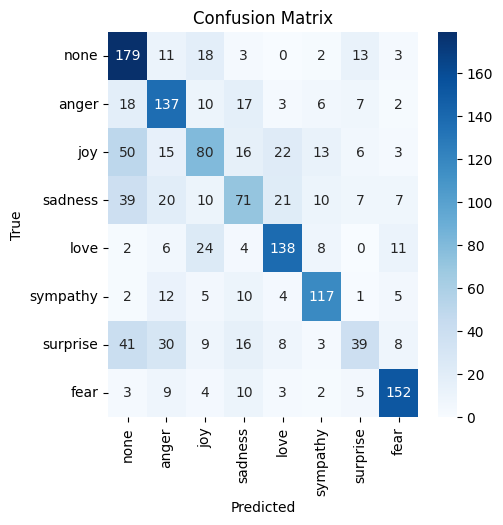

In [17]:
# creatin a confusion matrix
create_confusion_matrix(y_pred)

In [18]:
nb_vec = MultinomialNB(force_alpha=True, alpha=0.1, fit_prior=True)
nb_vec.fit(X_train_tfidf_ls, df_train['label'])

# test accuracy of tf-idf vectorizer
y_pred = nb_vec.predict(X_test_tfidf_ls.toarray())
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.609271523178808


In [19]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

              precision    recall  f1-score   support

        none       0.50      0.81      0.62       229
       anger       0.62      0.62      0.62       200
         joy       0.52      0.39      0.44       205
     sadness       0.49      0.31      0.38       185
        love       0.65      0.74      0.69       193
    sympathy       0.81      0.79      0.80       156
    surprise       0.55      0.30      0.39       154
        fear       0.74      0.87      0.80       188

    accuracy                           0.61      1510
   macro avg       0.61      0.60      0.59      1510
weighted avg       0.61      0.61      0.59      1510



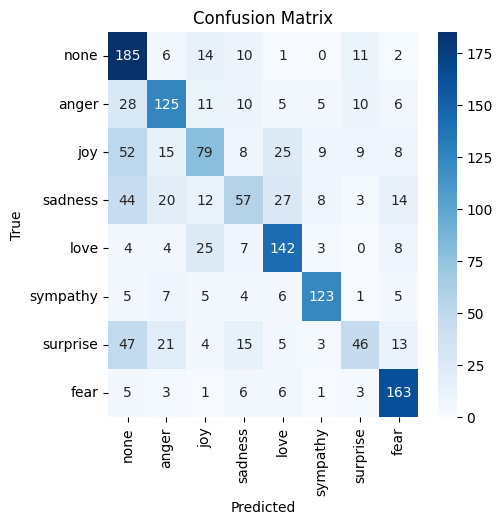

In [20]:
# creatin a confusion matrix
create_confusion_matrix(y_pred)

## Shap

In [21]:
'''
function that vectorizes the input data
then predicts using naive bayes model
parameters
texts: original text after preprocessing
'''
def model_predict(text):
  vec = tfidf_vectorizer_ls.transform(text)
  return nb_vec.predict_proba(vec)

In [22]:
'''
function that initializes shap with the appropriate model
parameters
model: an instance of your model, ex: LogisticRegression instance
'''
def initializeShap(model):
  # split input text into tokens
  masker = shap.maskers.Text(tokenizer=r"\W+")
  if isinstance(model, LogisticRegression):
    explainer = shap.Explainer(model_predict, masker=masker, output_names=label_to_class)
  elif isinstance(model, MultinomialNB):
    explainer = shap.Explainer(model_predict, masker=masker, output_names=label_to_class)
  else: print("Please use a valid model !")
  return explainer

In [23]:
nb_explainer = initializeShap(model=nb_vec)

In [24]:
def explain_example_shap(i):
  instance = df_test["Light Stemming"].iloc[i:i+1].values.astype(str).tolist()
  shap_values = nb_explainer(instance)
  shap.text_plot(shap_values)

In [25]:
y_true = df_test['label']

In [26]:
# get correctly and incorrectly classified examples
correctly_classified, incorrectly_classified = [], []
for i in range(len(y_true)):
  if y_pred[i] == y_true[i]:  correctly_classified.append(i)
  else: incorrectly_classified.append(i)

## find specific words

### loop through all incorrectly classifies examples and exctract the most common words that led to the wrong classfication

In [29]:
def get_word_frequency(df):
  # creating a dictionary to hold the number of times a specific word occurs
  word_frequency = {}
  for idx in incorrectly_classified:
    # tokenizing the words
    words_to_add = word_tokenize(df.iloc[idx])
    # looping through each word in list
    for word in words_to_add:
      if word in word_frequency:
        word_frequency[word] += 1
      else: word_frequency[word] = 1
  # soring the dictionary from most common words to least common
  sorted_list = sorted(word_frequency.items(), key=lambda word: word[1], reverse=True)
  return sorted_list

In [30]:
word_freq = get_word_frequency(df_test["cleaned_data"])

In [31]:
# getting 10 most common words
print(word_freq[:10])

[('الاوليمبياد', 181), ('فرح', 78), ('اللي', 64), ('لا', 52), ('مش', 50), ('مصر', 41), ('الله', 41), ('حب', 40), ('حاجه', 33), ('حزن', 33)]


### as we can see above are the most common words that lead to missclassification, lets try to understand why?

In [32]:
# see how the words above influence the classes
def word_occurance(word, df, y_pred):
  label_dic = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
  for idx in incorrectly_classified:
    if word in df.iloc[idx]:
      label_dic[y_pred[idx]] += 1
  # create a new dictionary using label_to_class as keys
  new_dict = {label: label_dic.get(index, 0) for index, label in enumerate(label_to_class)}
  return new_dict

In [33]:
problamatic_words = [word[0] for word in word_freq[:10]]
print(problamatic_words)

['الاوليمبياد', 'فرح', 'اللي', 'لا', 'مش', 'مصر', 'الله', 'حب', 'حاجه', 'حزن']


In [34]:
for word in problamatic_words:
  dic = word_occurance(word, df_test["cleaned_data"], y_pred)
  print(f"Classes for Word {word}:\n{dic}", end="\n\n")

Classes for Word الاوليمبياد:
{'none': 123, 'anger': 10, 'joy': 14, 'sadness': 10, 'love': 0, 'sympathy': 0, 'surprise': 16, 'fear': 6}

Classes for Word فرح:
{'none': 28, 'anger': 5, 'joy': 6, 'sadness': 2, 'love': 2, 'sympathy': 0, 'surprise': 3, 'fear': 6}

Classes for Word اللي:
{'none': 35, 'anger': 4, 'joy': 5, 'sadness': 3, 'love': 2, 'sympathy': 0, 'surprise': 6, 'fear': 6}

Classes for Word لا:
{'none': 151, 'anger': 47, 'joy': 41, 'sadness': 30, 'love': 34, 'sympathy': 18, 'surprise': 23, 'fear': 25}

Classes for Word مش:
{'none': 37, 'anger': 11, 'joy': 12, 'sadness': 7, 'love': 6, 'sympathy': 2, 'surprise': 11, 'fear': 6}

Classes for Word مصر:
{'none': 42, 'anger': 4, 'joy': 6, 'sadness': 3, 'love': 0, 'sympathy': 0, 'surprise': 2, 'fear': 1}

Classes for Word الله:
{'none': 10, 'anger': 6, 'joy': 17, 'sadness': 2, 'love': 7, 'sympathy': 8, 'surprise': 2, 'fear': 8}

Classes for Word حب:
{'none': 9, 'anger': 6, 'joy': 13, 'sadness': 7, 'love': 24, 'sympathy': 4, 'surprise'

## Misunderstanding of context

In [35]:
def explain_example_shap(i, class_to_explain):
  instance = df_test["Light Stemming"].iloc[i:i+1].values.astype(str).tolist()
  print(df_test["tweet"].iloc[i])
  shap_values = nb_explainer(instance)
  # shap.text_plot(shap_values)
  # waterfall plot
  shap.plots.waterfall(shap_values[0][:, class_to_explain])

In [36]:
def explain_example(idx):
  print(f"True Label {label_to_class_dic[y_true[idx]]} - Predicted Label {label_to_class_dic[y_pred[idx]]}")
  print(f"Explaining according to label {label_to_class_dic[y_pred[idx]]}")
  explain_example_shap(idx, y_pred[idx])

True Label fear - Predicted Label none
Explaining according to label none
طب هنعيش ازاي من غير رفع اثقال من هنا لحد الاوليمبياد الجايه بعد 4 سنين...؟؟


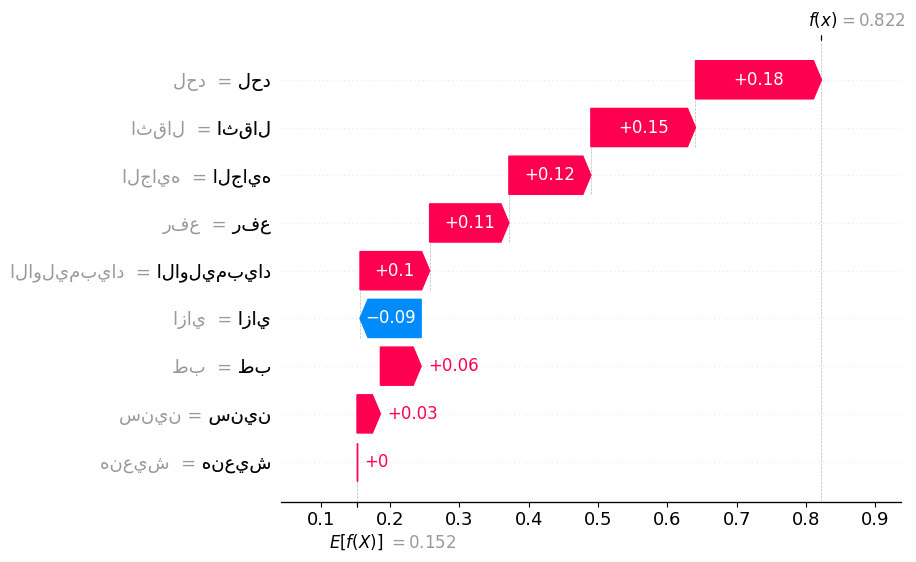

In [37]:
explain_example(incorrectly_classified[0])

about the previous example, true label is fear and it's predicted as none, however the true emotion is somewhat ambigouse

True Label anger - Predicted Label joy
Explaining according to label joy
tv علي عبدالله صالح صانع الوحده لا تنساء هذا واذكرك ان ازعيم لن يفرط في الوحده لو كلفته حياته. خليهاء في راسك مسمار مسمم


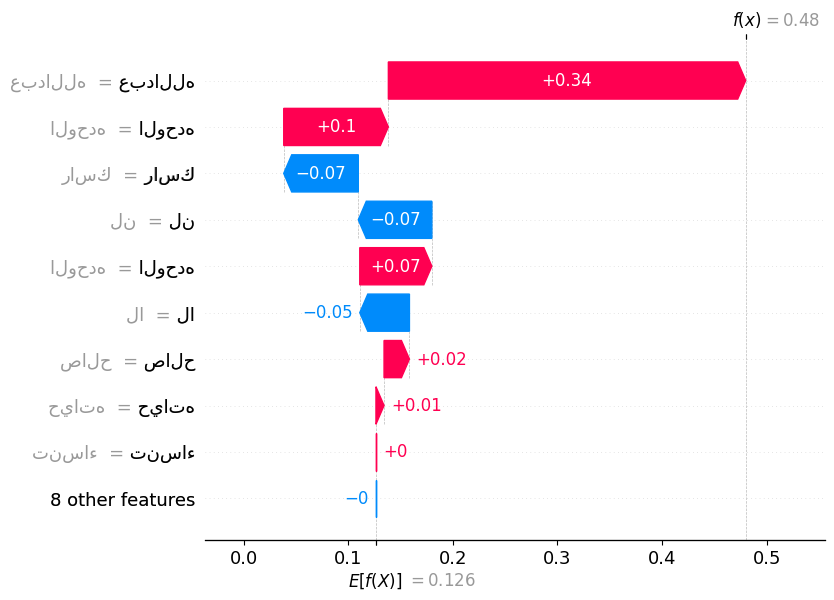

In [38]:
explain_example(incorrectly_classified[1])

here it's labeled as anger and predicted as joy
however like the example before, it's hard to label that example.

True Label joy - Predicted Label none
Explaining according to label none
الاوليمبياد السنه دي افشخ من سيدني اللي كنا بنزوغ من المدرسه علشان نتفرج عليها 😀


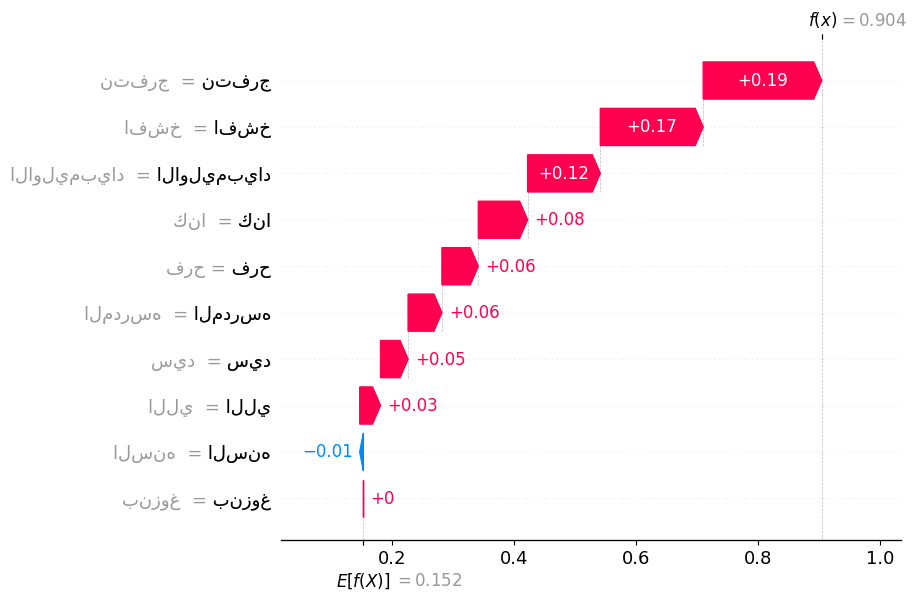

In [39]:
explain_example(incorrectly_classified[2])

here there's a clear missunderstanding of the context, the word "نتفرج" leads to a high score for none prediction, and the word "افشخ" which in this context clearly shows emotions of joy, leads to a none prediction which doesn't make sense.

True Label fear - Predicted Label anger
Explaining according to label anger
اعتقال مغربي قتل اسبانيا بشكل مروع | ماذا جري


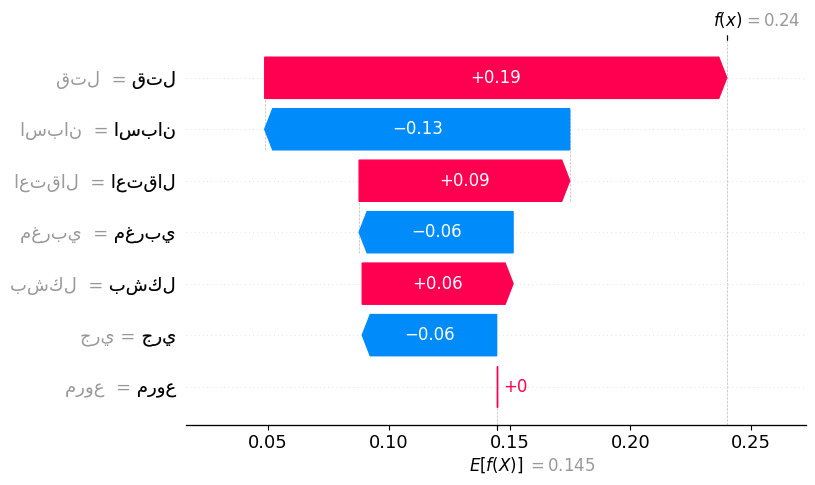

In [40]:
explain_example(incorrectly_classified[3])

here the label is fear, predicted is anger, but there are alot of mixed feelings like surprise, sadness and fear, which make it hard to pick one, however anger is clearly not the correct prediction.

True Label sadness - Predicted Label none
Explaining according to label none
المصريين داخلين الاوليمبياد تمثيل مشرف


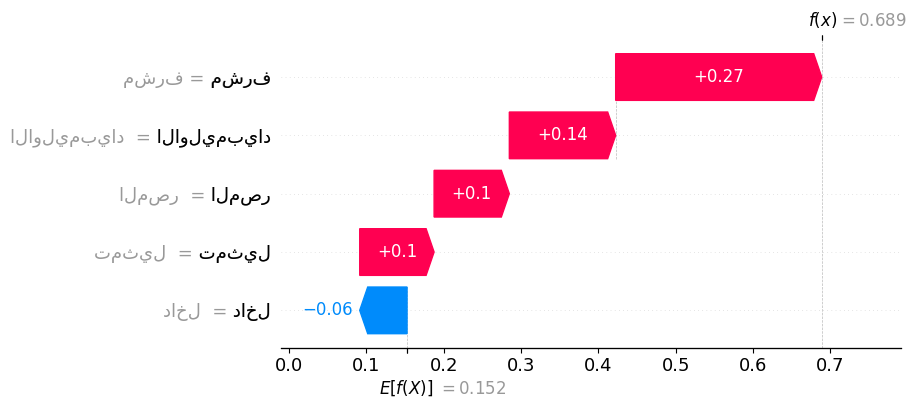

In [41]:
explain_example(incorrectly_classified[4])

here the model predicted none but the true label is sadness, which doesn't make sense, this tweet shows pride, which maybe can lead to joy? however none is an understandable prediction because it doesn't show any one of the these emotions strongly.

True Label anger - Predicted Label none
Explaining according to label none
وده سؤال اللي عايش في مصر  كل يوم خازوق اصلا


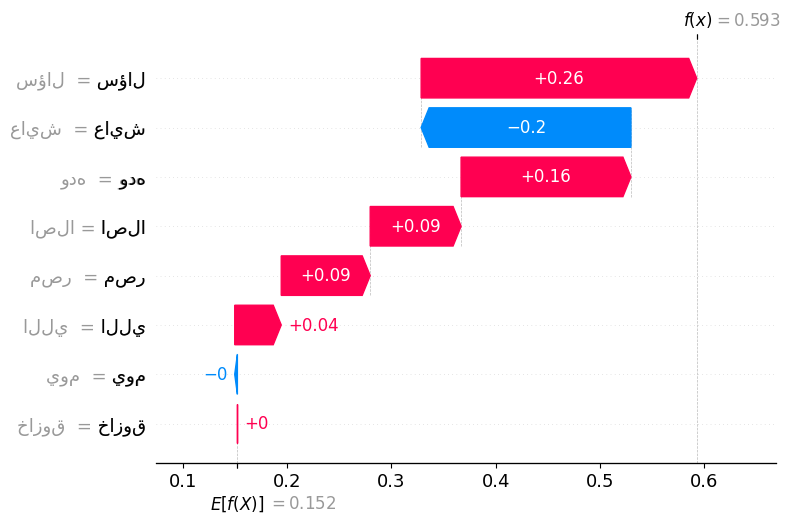

In [57]:
explain_example(incorrectly_classified[16])

here the model didn't understand the word "خازوق" which is the only word in the sentence that lead to the anger prediction.

True Label joy - Predicted Label none
Explaining according to label none
حسناً من الواضح اننا سنتابع الاوليمبياد . 🤔😄


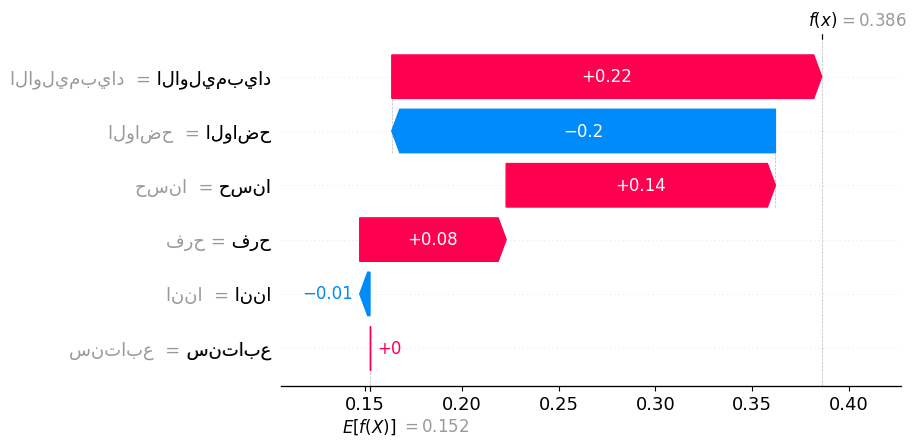

In [61]:
explain_example(incorrectly_classified[19])

maybe the emojis lead to that label? because without the emojis it makes sense to be none.

#### from the above examples, it's pretty obvious that there are problems with the labeling of the examples.

#### even sometimes the model predicts the class that makes the most sense but that prediction is differenct from the 'true label' which doesn't make much sense.

#### if the model trained on poorly classified labels like this, then we predict that correcting the labels should result on better performance.

## Clearly wrong labels

True Label fear - Predicted Label surprise
Explaining according to label surprise
: مُش معقول انا ايدي لامسه ايديك .. خايف اكون يا حبيبي بحلم بيك.


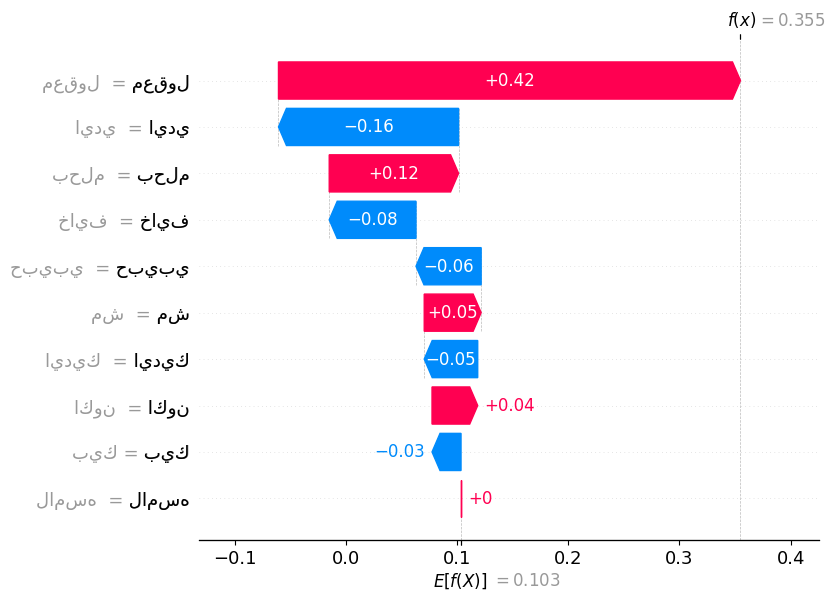

In [62]:
explain_example(incorrectly_classified[5])

True Label none - Predicted Label joy
Explaining according to label joy
دول افريفيا مبوزه سمعتنا في الاوليمبياد


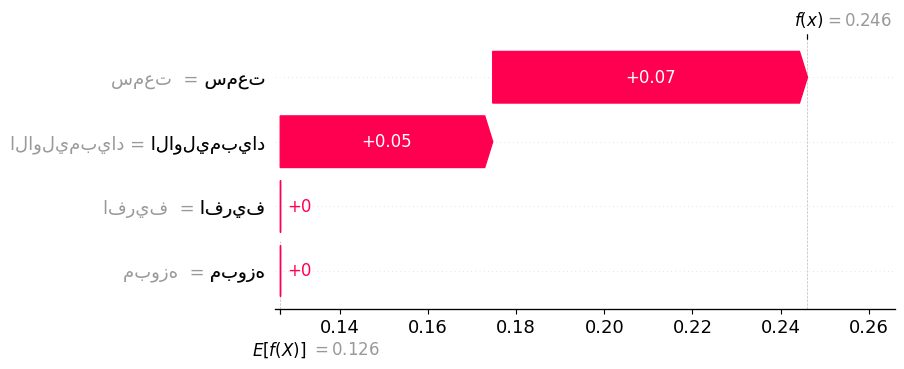

In [84]:
explain_example(incorrectly_classified[22])

above true label is fear, predicted is surprise.
from that statement it's obvious that it's not fear, and surprise makes more sense.

## Different dialacts

True Label joy - Predicted Label none
Explaining according to label none
الاوليمبياد السنه دي افشخ من سيدني اللي كنا بنزوغ من المدرسه علشان نتفرج عليها 😀


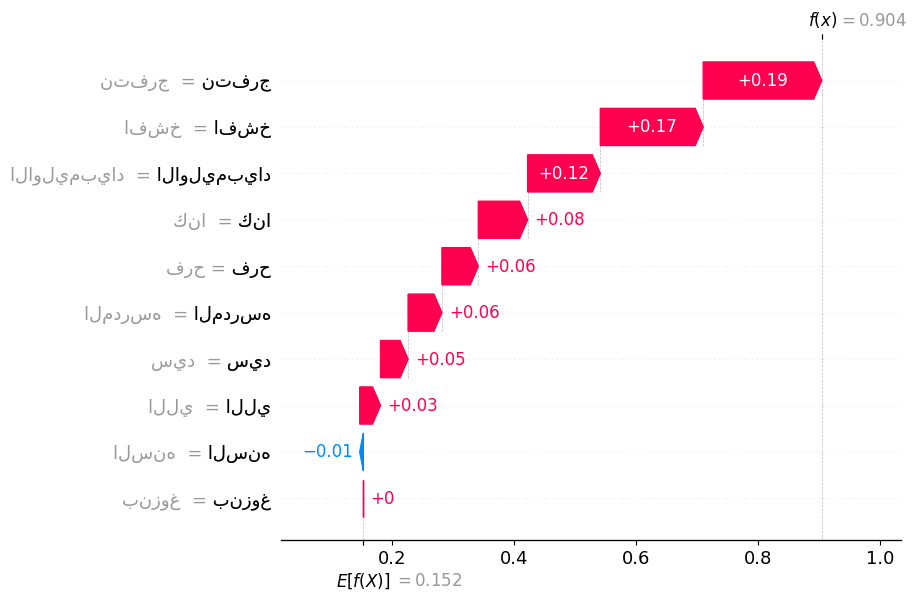

In [53]:
explain_example(incorrectly_classified[2])

True Label fear - Predicted Label anger
Explaining according to label anger
اعتقال مغربي قتل اسبانيا بشكل مروع | ماذا جري


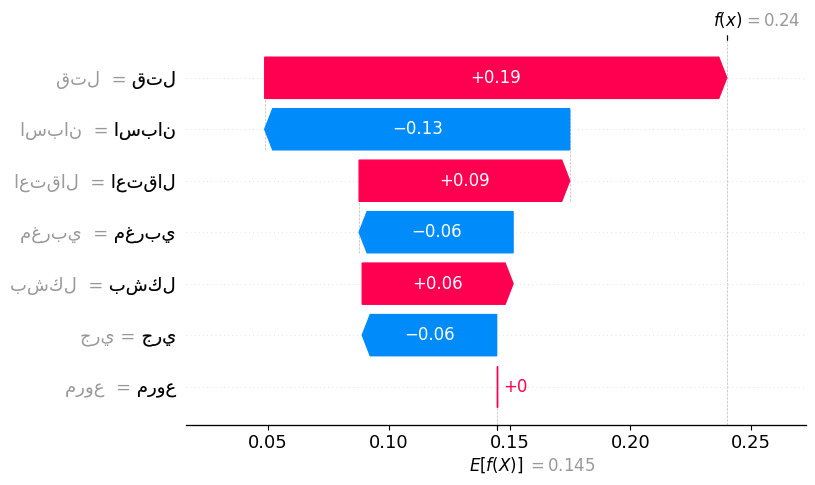

In [54]:
explain_example(incorrectly_classified[3])

True Label sadness - Predicted Label joy
Explaining according to label joy
مني لاتقول الحطـب طـاح عاتب علي كيفك وريـح ضميـرك  اخطيت في حقك وعيييت لاارتـاح ياليتني مخطي مع انسـان غيـرك


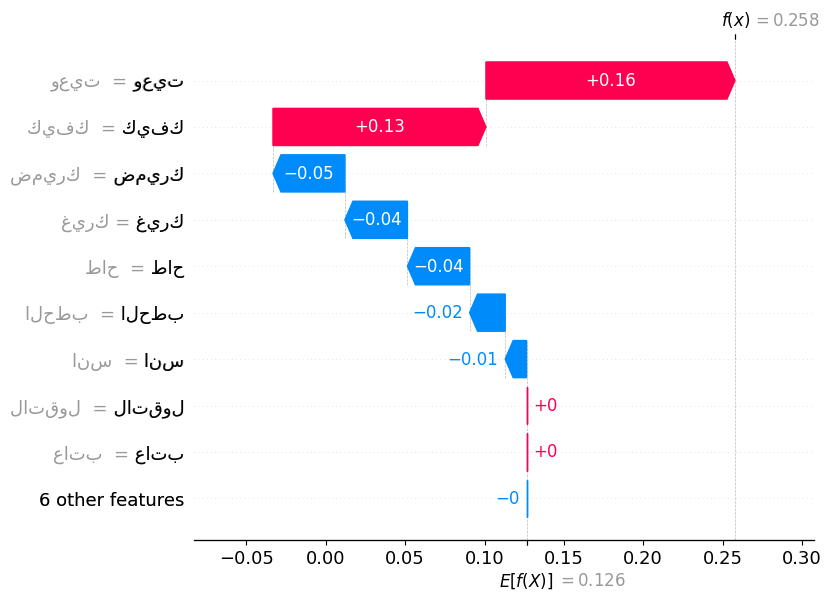

In [52]:
explain_example(incorrectly_classified[14])

## short statements

In [63]:
short_statements = []
for i in range(len(df_test)):
  if len(df_test["Light Stemming"].iloc[i]) <= 5:
    short_statements.append(i)

In [64]:
len(short_statements)

15

In [65]:
idx = 0
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")


True Label: none - Predicted Label: none


In [66]:
idx = 1
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

الفل
True Label: joy - Predicted Label: joy


In [67]:
idx = 2
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

سعيده
True Label: joy - Predicted Label: joy


In [68]:
idx = 3
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

وقلبي
True Label: sympathy - Predicted Label: love


In [69]:
idx = 4
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

عايش
True Label: surprise - Predicted Label: sadness


In [70]:
idx = 5
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

ازعل
True Label: surprise - Predicted Label: sadness


as we can see there are a lot of one word tweets and 15 tweets of length 5 or less, there's and even empty tweet after preprocessing.

## Mixed feelings

True Label joy - Predicted Label none
Explaining according to label none
جايز جدا وممكن بالعوامه البطه في الاوليمبياد الجاي😂😂😂😂😂😂😂


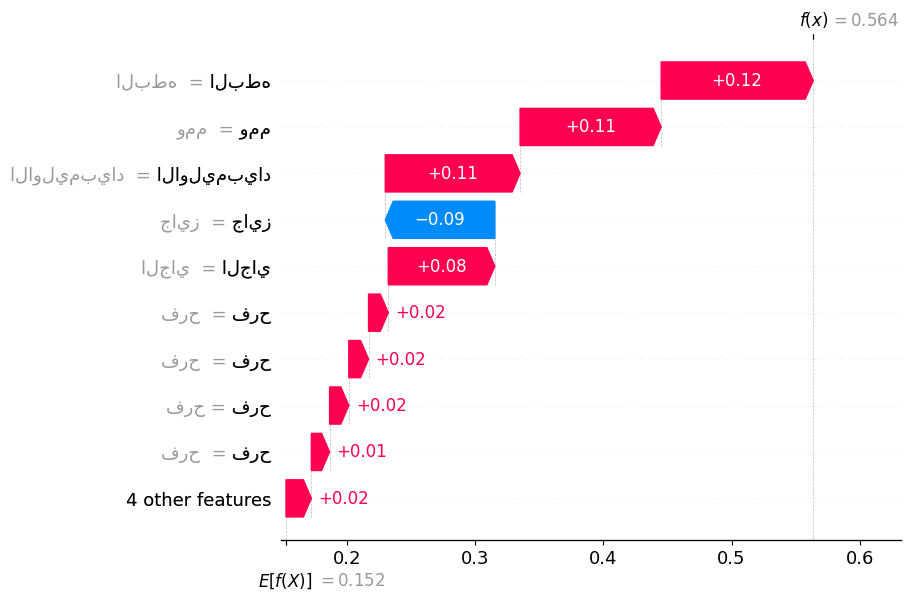

In [72]:
explain_example(incorrectly_classified[10])

here we have mixed feelings for that person that "you love" and the sadness from not having them.

True Label joy - Predicted Label love
Explaining according to label love
صوتك ده ايه الله عليه ملايكه بيغنوا ...


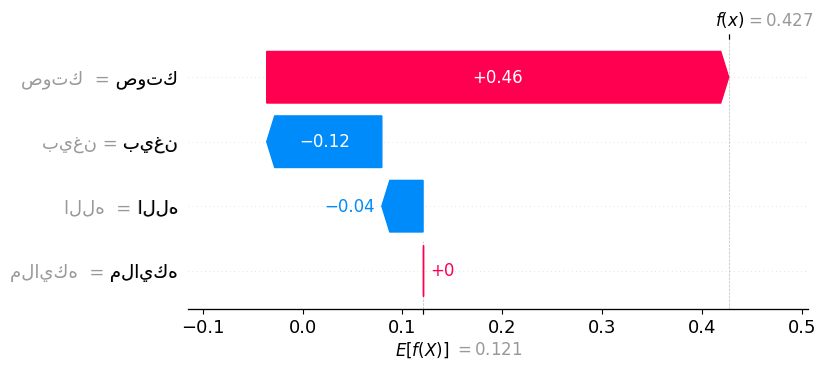

In [74]:
explain_example(incorrectly_classified[12])

here we have mixed emotions between joy and love, love for that beatiful sound and joy for hearing it, and it's hard to pick one.

True Label sympathy - Predicted Label joy
Explaining according to label joy
الله يسعدكم. ويكون معكم


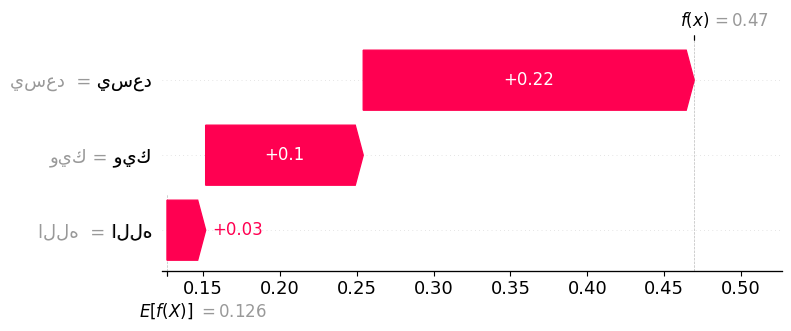

In [78]:
explain_example(incorrectly_classified[13])

## Is there a lack of sufficient training data for a particular label?

In [71]:
df_train['label'].value_counts()

0    1074
1    1019
2     891
3     885
4     850
7     842
5     755
6     729
Name: label, dtype: int64

class surprise has 300+ less examples than none, but is that enough to make a big difference?
however when you think about it in terms of ratio 300 is almost a third of number of examples of none.

### Observation: root stemming seems to break the words meaning and reduce accuracy below the no stemming, however light stemming seems to preserve word meaning and even improve the baseline accuracy